V12: Fix Data Augmentation (Resize)

In [1]:
%%capture
# https://www.kaggle.com/timesler/facial-recognition-model-in-pytorch
# Install facenet-pytorch
!pip install /kaggle/input/facenet-pytorch-vggface2/facenet_pytorch-1.0.1-py3-none-any.whl
# Copy model checkpoints to torch cache so they are loaded automatically by the package
!mkdir -p /tmp/.cache/torch/checkpoints/
!cp /kaggle/input/facenet-pytorch-vggface2/20180402-114759-vggface2-logits.pth /tmp/.cache/torch/checkpoints/vggface2_DG3kwML46X.pt
!cp /kaggle/input/facenet-pytorch-vggface2/20180402-114759-vggface2-features.pth /tmp/.cache/torch/checkpoints/vggface2_G5aNV2VSMn.pt

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import gc
import cv2
import glob
import time
import copy
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms
from facenet_pytorch import MTCNN, InceptionResnetV1

In [3]:
import sys
package_path = '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'
sys.path.append(package_path)

from efficientnet_pytorch import EfficientNet

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [5]:
seed_everything(0)

In [6]:
sorted(os.listdir('../input/deepfake-efficientnet2d-model-weight-2'))

['efficientnet_b0_10_epoch_44_loss_0.121.pth',
 'efficientnet_b0_5_epoch_28_loss_0.125.pth',
 'efficientnet_b0_6_epoch_28_loss_0.136.pth',
 'efficientnet_b0_7_epoch_23_loss_0.128.pth',
 'efficientnet_b4_2_epoch_42_loss_0.105.pth',
 'efficientnet_b4_3_epoch_44_loss_0.113.pth',
 'efficientnet_b4_4_epoch_5_loss_0.100.pth',
 'efficientnet_b4_5_epoch_10_loss_0.116.pth',
 'efficientnet_b4_5_epoch_17_loss_0.112.pth',
 'efficientnet_b4_6_epoch_19_loss_0.180.pth',
 'efficientnet_b6_2_epoch_3_loss_0.120.pth',
 'efficientnet_lstm_b0_3_epoch_6_loss_0.098.pth',
 'efficientnet_lstm_b0_4_epoch_6_loss_0.102.pth']

In [7]:
# Set Trained Weight Path
weight_path = 'efficientnet_b4_6_epoch_19_loss_0.180.pth'
trained_weights_path = os.path.join('../input/deepfake-efficientnet2d-model-weight-2', weight_path)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark=True

In [8]:
device

device(type='cuda', index=0)

In [9]:
test_dir = '../input/deepfake-detection-challenge/test_videos'
os.listdir(test_dir)[:5]

['ywauoonmlr.mp4',
 'sfsayjgzrh.mp4',
 'sngjsueuhs.mp4',
 'eryjktdexi.mp4',
 'nwvloufjty.mp4']

In [10]:
def get_img_from_mov(video_file, num_img, frame_window):
    # https://note.nkmk.me/python-opencv-videocapture-file-camera/
    cap = cv2.VideoCapture(video_file)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    image_list = []
    for i in range(num_img):
        _, image = cap.read()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_list.append(image)
        cap.set(cv2.CAP_PROP_POS_FRAMES, (i + 1) * frame_window)
        if cap.get(cv2.CAP_PROP_POS_FRAMES) >= frames:
            break
    cap.release()

    return image_list

In [11]:
class ImageTransform:
    def __init__(self, size, mean, std):
        self.data_transform = transforms.Compose([
                transforms.Resize((size, size), interpolation=Image.BILINEAR),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

    def __call__(self, img):
        return self.data_transform(img)

In [12]:
class DeepfakeDataset(Dataset):
    def __init__(self, file_list, device, detector, transform, img_num=20, frame_window=10):
        self.file_list = file_list
        self.device = device
        self.detector = detector
        self.transform = transform
        self.img_num = img_num
        self.frame_window = frame_window

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):

        mov_path = self.file_list[idx]
        img_list = []

        # Movie to Image
        try:
            all_image = get_img_from_mov(mov_path, self.img_num, self.frame_window)
        except:
            return [], mov_path.split('/')[-1]
        
        # Detect Faces
        for image in all_image:
            
            try:
                _image = image[np.newaxis, :, :, :]
                boxes, probs = self.detector.detect(_image, landmarks=False)
                x = int(boxes[0][0][0])
                y = int(boxes[0][0][1])
                z = int(boxes[0][0][2])
                w = int(boxes[0][0][3])
                image = image[y-15:w+15, x-15:z+15]
                
                # Preprocessing
                image = Image.fromarray(image)
                image = self.transform(image)
                
                img_list.append(image)

            except:
                img_list.append(None)
            
        # Padding None
        img_list = [c for c in img_list if c is not None]
        
        return img_list, mov_path.split('/')[-1]

---
# Model

In [13]:
# Centerloss Version
# class Efficientnet_centerloss(nn.Module):

#     def __init__(self, output_size, model_name='efficientnet-b0'):
#         super(Efficientnet_centerloss, self).__init__()

#         self.base = EfficientNet.from_name(model_name)
#         self.base._fc = nn.Linear(in_features=self.base._fc.in_features, out_features=512)
#         self.model_name = model_name

#         self.global_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
#         self.fc_1 = nn.Linear(512, 64, bias=True)
#         self.dropout = nn.Dropout(0.5)
#         self.ip1 = nn.Linear(64, 2)
#         self.fc_last = nn.Linear(2, output_size, bias=True)

#     def forward(self, x):
#         x = self.base(x)

#         x = self.fc_1(x)
#         x = self.dropout(x)
#         ip1 = self.ip1(x)
#         x = self.fc_last(ip1)

#         return x

In [14]:
# model = Efficientnet_centerloss(output_size=1, model_name='efficientnet-b0')
# model.load_state_dict(torch.load(trained_weights_path, map_location=torch.device(device)))

In [15]:
# Original Version
model = EfficientNet.from_name('efficientnet-b4')
model._fc = nn.Linear(in_features=model._fc.in_features, out_features=1)
model.load_state_dict(torch.load(trained_weights_path, map_location=torch.device(device)))

<All keys matched successfully>

---
# Prediction

In [16]:
test_file = [os.path.join(test_dir, path) for path in os.listdir(test_dir)]

In [17]:
test_file[:5]

['../input/deepfake-detection-challenge/test_videos/ywauoonmlr.mp4',
 '../input/deepfake-detection-challenge/test_videos/sfsayjgzrh.mp4',
 '../input/deepfake-detection-challenge/test_videos/sngjsueuhs.mp4',
 '../input/deepfake-detection-challenge/test_videos/eryjktdexi.mp4',
 '../input/deepfake-detection-challenge/test_videos/nwvloufjty.mp4']

In [18]:
# Prediction
def predict_dfdc(dataset, model):
    
    torch.cuda.empty_cache()
    pred_list = []
    path_list = []
    
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        for i in tqdm(range(len(dataset))):
            pred = 0
            imgs, mov_path = dataset.__getitem__(i)
            
            # No get Image
            if len(imgs) == 0:
                pred_list.append(0.5)
                path_list.append(mov_path)
                continue
                
                
            for i in range(len(imgs)):
                img = imgs[i]
                
                output = model(img.unsqueeze(0).to(device))
                pred += torch.sigmoid(output).item() / len(imgs)
                
            pred_list.append(pred)
            path_list.append(mov_path)
            
    torch.cuda.empty_cache()
            
    return path_list, pred_list

In [19]:
# Config
img_size = 120
img_num = 15
frame_window = 5
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(img_size, mean, std)

detector = MTCNN(image_size=img_size, margin=14, keep_all=False, factor=0.5, 
                 select_largest=False, post_process=False, device=device).eval()

dataset = DeepfakeDataset(test_file, device, detector, transform, img_num, frame_window)

path_list, pred_list = predict_dfdc(dataset, model)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [20]:
# Submission
res = pd.DataFrame({
    'filename': path_list,
    'label': pred_list,
})

res.sort_values(by='filename', ascending=True, inplace=True)

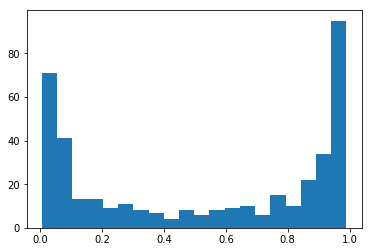

In [21]:
plt.hist(res['label'], 20)
plt.show()

In [22]:
res.head(10)

,filename,label
374,aassnaulhq.mp4,0.899037
247,aayfryxljh.mp4,0.012424
339,acazlolrpz.mp4,0.891982
193,adohdulfwb.mp4,0.007394
315,ahjnxtiamx.mp4,0.738787
248,ajiyrjfyzp.mp4,0.645911
367,aktnlyqpah.mp4,0.961957
340,alrtntfxtd.mp4,0.912442
292,aomqqjipcp.mp4,0.963147
348,apedduehoy.mp4,0.039599


In [23]:
res.to_csv('submission.csv', index=False)

---
## Post Process

In [24]:
_res = res.copy()

x_min = _res['label'].min()
x_max = _res['label'].max()

set_min = 0.1
set_max = 0.9

def postprocess(x):
    return (x - x_min) * (set_max - set_min) / (x_max - x_min) + set_min

_res['label'] = res['label'].apply(postprocess)

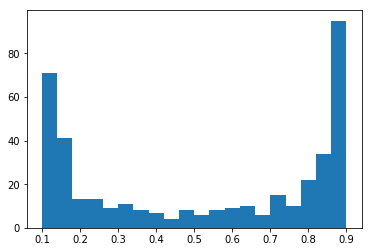

In [25]:
plt.hist(_res['label'], 20)
plt.show()

In [26]:
_res.head(10)

,filename,label
374,aassnaulhq.mp4,0.826302
247,aayfryxljh.mp4,0.105597
339,acazlolrpz.mp4,0.820567
193,adohdulfwb.mp4,0.101508
315,ahjnxtiamx.mp4,0.696038
248,ajiyrjfyzp.mp4,0.620541
367,aktnlyqpah.mp4,0.877447
340,alrtntfxtd.mp4,0.837198
292,aomqqjipcp.mp4,0.878415
348,apedduehoy.mp4,0.127687


In [27]:
# _res.to_csv('submission.csv', index=False)